### [1] 패키지 불러오기

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image

### [2] Data transform 정의

In [2]:
import torchvision.transforms as transforms

# 이미지 전처리
size = [230, 230]
center_size = [224, 224]

TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] 구글 드라이브 연동

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [4] MultimodalEyeDataset 클래스 정의

In [4]:
class MultimodalEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # 이미지 불러오기
        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        # 임상정보: gender -> one-hot 인코딩, norm_age
        norm_age = torch.tensor(item['age'], dtype=torch.float32)
        gender = item['gender']  # 0 or 1
        gender_one_hot = torch.tensor([1, 0], dtype=torch.float32) if gender == 0 else torch.tensor([0, 1], dtype=torch.float32)

        clinical = torch.cat([norm_age.unsqueeze(0), gender_one_hot])  # shape: [3]

        label = torch.tensor(item['label'], dtype=torch.long)

        return left_img, right_img, clinical, label

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        print(f"usable multimodal samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)


### [5] train_loader, val_loader, test_loader 구성

In [5]:
# 경로 설정
json_file = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 학습용 데이터셋 (group 1)
train_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=1,
    include_0_9mm=True,
    transform=TrainTransform
)

# 검증용 데이터셋 (group 2)
val_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=2,
    include_0_9mm=True,
    transform=ValidTransform
)

# 테스트용 데이터셋 (group 3)
test_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=3,
    include_0_9mm=True,
    transform=ValidTransform
)

from torch.utils.data import DataLoader

# 최적화 설정: num_workers=2, pin_memory=True
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable multimodal samples for group 1: 2603
usable multimodal samples for group 2: 200
usable multimodal samples for group 3: 100


### [6] Multimodal 모델 클래스 정의

In [6]:
import torch
import torch.nn as nn
import timm

class MultimodalModel(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(MultimodalModel, self).__init__()

        # 이미지 backbone: 좌/우 이미지 처리
        self.backbone = timm.create_model('seresnext50_32x4d.racm_in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        # 임상정보 FC: [gender one-hot 인코딩, norm_age] → 128
        self.clinical_fc = nn.Sequential(
            nn.Linear(3, 128),  # 3차원 입력
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )

        # 최종 분류기: 이미지(2048*2) + clinical(128) → 2-class output
        self.classifier = nn.Sequential(
            nn.Linear(2048 * 2 + 128, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)
        )

    def forward(self, left, right, clinical):
        # 이미지 feature 추출
        left_feat = self.backbone(left)   # (B, 2048), B = Batch size
        right_feat = self.backbone(right) # (B, 2048)
        image_feat = torch.cat([left_feat, right_feat], dim=1)  # (B, 4096)
        image_feat = self.dropout(image_feat)

        # 임상 feature 임베딩
        clinical_feat = self.clinical_fc(clinical)  # (B, 128)

        # 결합 후 분류
        fused = torch.cat([image_feat, clinical_feat], dim=1)  # (B, 4224)
        output = self.classifier(fused)  # (B, 2)

        return output


### [7] FocalLoss 클래스 정의

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


### [8] 학습 루프 + loss 그래프

In [8]:
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
import json

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = MultimodalModel().to(device)

# 손실 함수
criterion = FocalLoss()

# 옵티마이저 (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 학습률 스케줄러
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 하이퍼파라미터
epochs = 50
best_val_loss = float('inf')

# 손실 기록 리스트
train_losses = []
val_losses = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for left, right, clinical, labels in train_loader:
        left, right, clinical, labels = left.to(device), right.to(device), clinical.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(left, right, clinical)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left, right, clinical, labels in val_loader:
            left, right, clinical, labels = left.to(device), right.to(device), clinical.to(device), labels.to(device)

            outputs = model(left, right, clinical)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    train_loss = running_loss / len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step()

    # Best 모델 저장 (Val Loss 기준)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/02multimodal/best_multimodal_model_1e-4.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    # Epoch 출력
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# Loss를 JSON으로 저장
loss_history = {
    'train_loss': train_losses,
    'val_loss': val_losses
}

with open('/content/drive/MyDrive/cv_project/02multimodal/loss_history_1e-4.json', 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history.json 저장 완료!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

Best model updated at epoch 1 (Val Loss: 0.2422)
Epoch 1/50 | Train Loss: 0.1300 | Val Loss: 0.2422 | Val Acc: 0.6350 | LR: 0.000100
Best model updated at epoch 2 (Val Loss: 0.1551)
Epoch 2/50 | Train Loss: 0.1195 | Val Loss: 0.1551 | Val Acc: 0.7200 | LR: 0.000100
Best model updated at epoch 3 (Val Loss: 0.1504)
Epoch 3/50 | Train Loss: 0.1149 | Val Loss: 0.1504 | Val Acc: 0.6750 | LR: 0.000100
Epoch 4/50 | Train Loss: 0.1109 | Val Loss: 0.1525 | Val Acc: 0.6700 | LR: 0.000100
Epoch 5/50 | Train Loss: 0.1087 | Val Loss: 0.1644 | Val Acc: 0.6650 | LR: 0.000100
Best model updated at epoch 6 (Val Loss: 0.1414)
Epoch 6/50 | Train Loss: 0.1066 | Val Loss: 0.1414 | Val Acc: 0.7200 | LR: 0.000100
Epoch 7/50 | Train Loss: 0.1000 | Val Loss: 0.1756 | Val Acc: 0.6450 | LR: 0.000100
Epoch 8/50 | Train Loss: 0.1003 | Val Loss: 0.1544 | Val Acc: 0.7300 | LR: 0.000100
Epoch 9/50 | Train Loss: 0.0937 | Val Loss: 0.2138 | Val Acc: 0.6450 | LR: 0.000100
Epoch 10/50 | Train Loss: 0.0878 | Val Loss: 0.1

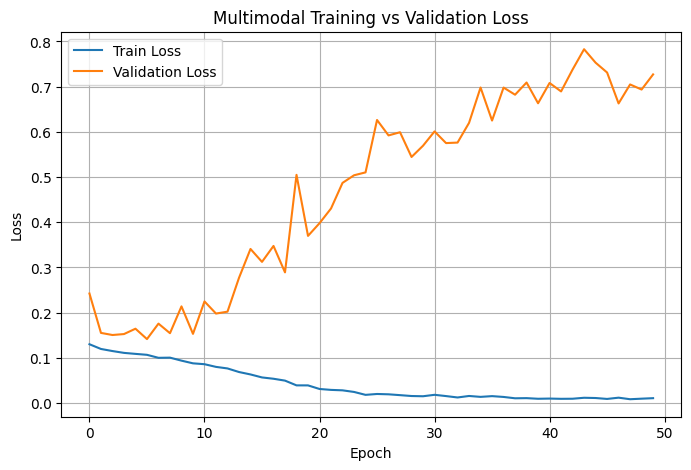

In [9]:
import matplotlib.pyplot as plt

# Loss 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multimodal Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### [9] predict_result.json 저장

In [10]:
import torch
import torch.nn.functional as F
import json
from tqdm import tqdm

# best 모델 불러오기
model = MultimodalModel(dropout_p=0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/02multimodal/best_multimodal_model_1e-4.pth'))
model.eval()

predict_result = {}

with torch.no_grad():
    for i, (left, right, clinical, labels) in enumerate(tqdm(test_loader)):
        left, right, clinical, labels = left.to(device), right.to(device), clinical.to(device), labels.to(device)
        outputs = model(left, right, clinical)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        # 배치 단위로 결과 저장
        for j in range(len(labels)):
            sample_idx = i * test_loader.batch_size + j
            sample_id = list(test_dataset.data)[sample_idx]  # test_dataset.data는 dict list
            predict_result[sample_id['left_eye'].split('_')[0]] = {
                'label': int(labels[j].cpu().item()),
                'pred': int(preds[j].cpu().item()),
                'score': probs[j].cpu().tolist()
            }

# JSON 저장
save_path = '/content/drive/MyDrive/cv_project/02multimodal/predict_result_1e-4.json'
with open(save_path, 'w') as f:
    json.dump(predict_result, f, indent=2)

print(f"저장 완료: {save_path}")


100%|██████████| 7/7 [01:43<00:00, 14.83s/it]

저장 완료: /content/drive/MyDrive/cv_project/02multimodal/predict_result_1e-4.json


### [10] 평가 + AUC Curve 그리기

정확도 (Accuracy): 0.7800
AUC-ROC: 0.8812

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.91      0.62      0.74        50
   Thickened       0.71      0.94      0.81        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100

Confusion Matrix:
[[31 19]
 [ 3 47]]


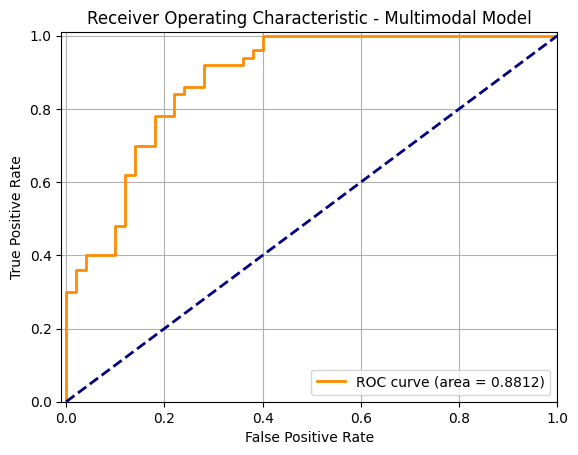

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# 결과 불러오기
with open('/content/drive/MyDrive/cv_project/02multimodal/predict_result_1e-4.json', 'r') as f:
    results = json.load(f)

# y값 추출
y_true = [item['label'] for item in results.values()]
y_pred = [item['pred'] for item in results.values()]
y_score = [item['score'][1] for item in results.values()]  # thickened 확률

# 평가 지표 계산
acc = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_score)
report = classification_report(y_true, y_pred, target_names=['Normal', 'Thickened'])
cm = confusion_matrix(y_true, y_pred)

# 출력
print(f"정확도 (Accuracy): {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\n분류 리포트:")
print(report)
print("Confusion Matrix:")
print(cm)

# AUC-ROC 그래프 시각화
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multimodal Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




---


## 전체 성능 요약
[멀티모달 모델]
- 정확도 (Accuracy): 81.00%
- AUC-ROC: 90.41%

[현재 모델]
- 학습률: 1e-4
- 정확도 (Accuracy): 78.00%
- AUC-ROC: 88.12%
